# Stable Diffusion KLMC2 Animation

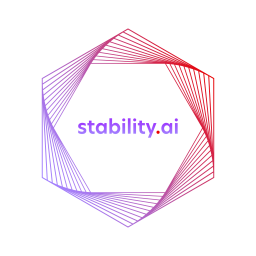


Notebook by [Katherine Crowson](https://twitter.com/RiversHaveWings)

Sponsored by [StabilityAI](https://twitter.com/stabilityai)

Generate animations with [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) 1.4, using the [KLMC2 discretization of underdamped Langevin dynamics](https://arxiv.org/abs/1807.09382). The notebook is largely inspired by [Ajay Jain](https://twitter.com/ajayj_) and [Ben Poole](https://twitter.com/poolio)'s paper [Journey to the BAOAB-limit](https://www.ajayjain.net/journey)&mdash;thank you so much for it!

---

## Modifications Provenance

Original notebook URL - [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1m8ovBpO2QilE2o4O-p2PONSwqGn4_x2G)

Features and QOL Modifications by [David Marx](https://twitter.com/DigThatData) - [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dmarx/notebooks/blob/main/Stable_Diffusion_KLMC2_Animation.ipynb)

* Keyframed Prompts
* Set seed
* Mount Google Drive
* Faster Setup
* Set output filename
* Fancy GPU info
* Video embed optional
* Cheaper default runtime

In [ ]:
#@title Check GPU
#!nvidia-smi

import pandas as pd
import subprocess

def gpu_info():
    outv = subprocess.run([
        'nvidia-smi',
            # these lines concatenate into a single query string
            '--query-gpu='
            'timestamp,'
            'name,'
            'utilization.gpu,'
            'utilization.memory,'
            'memory.used,'
            'memory.free,'
            ,
        '--format=csv'
        ],
        stdout=subprocess.PIPE).stdout.decode('utf-8')

    header, rec = outv.split('\n')[:-1]
    return pd.DataFrame({' '.join(k.strip().split('.')).capitalize():v for k,v in zip(header.split(','), rec.split(','))}, index=[0]).T

gpu_info()

In [ ]:
#@title Install Deps

# @markdown Your runtime will automatically restart after running this cell.
# @markdown You should only need to run this cell when setting up a new runtime. After future runtime restarts,
# @markdown you should be able to skip this cell.

!pip install ftfy einops braceexpand requests transformers clip open_clip_torch omegaconf pytorch-lightning kornia k-diffusion ninja
#!pip install -U torch torchvision
!pip install -U git+https://github.com/huggingface/huggingface_hub
!pip install napm

#####################
# Install more Deps #
#####################

#!git clone https://github.com/Stability-AI/stablediffusion
#!git clone https://github.com/CompVis/stable-diffusion
#!git clone https://github.com/CompVis/taming-transformers
#!git clone https://github.com/CompVis/latent-diffusion

# !pip install -v -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers

exit() # oh is this a way to restart the runtime? clever!

In [ ]:
# @markdown # Main Setup { display-mode: "form" }

###################
# Setup Workspace #
###################

import os
from pathlib import Path

mount_gdrive = False # @param {type:'boolean'}

# defaults
outdir = Path('./frames')
if not os.environ.get('XDG_CACHE_HOME'):
    os.environ['XDG_CACHE_HOME'] = str(Path('~/.cache').expanduser())

if mount_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')
    Path('/content/drive/MyDrive/AI/models/.cache/').mkdir(parents=True, exist_ok=True) 
    os.environ['XDG_CACHE_HOME']='/content/drive/MyDrive/AI/models/.cache'
    outdir = Path('/content/drive/MyDrive/AI/klmc2/frames/')

# make sure the paths we need exist
outdir.mkdir(parents=True, exist_ok=True)
os.environ['NAPM_PATH'] = str( Path(os.environ['XDG_CACHE_HOME']) / 'napm' )
Path(os.environ['NAPM_PATH']).mkdir(parents=True, exist_ok=True)


import napm

url = 'https://github.com/Stability-AI/stablediffusion'
napm.pseudoinstall_git_repo(url, add_install_dir_to_path=True)


###########
# imports #
###########

import napm

from base64 import b64encode
from collections import defaultdict
from concurrent import futures
import math
from pathlib import Path
import sys

import functorch
from IPython import display
import k_diffusion as K
from omegaconf import OmegaConf
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm, trange

#sys.path.extend(['./stablediffusion'])
from ldm.util import instantiate_from_config

from requests.exceptions import HTTPError
import huggingface_hub

from urllib.parse import urlparse

#########################
# Define useful globals #
#########################

cpu = torch.device("cpu")
device = torch.device("cuda")

############################

model_dir_str=str(Path(os.environ['XDG_CACHE_HOME']))

sdmodelid2hfrepo = {
    "sd-v1-4":"CompVis/stable-diffusion-v-1-4-original",
    "sd-v1-5":"runwayml/stable-diffusion-v1-5",
}

sdmodelid2hfckpt = {
    "sd-v1-4":"sd-v1-4.ckpt",
    "sd-v1-5":"v1-5-pruned-emaonly.ckpt",
}

sdmodelid2yamlurl = {
    "sd-v1-4":"https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml",
    "sd-v1-5":"https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml",
}

sdmodelid2ckptstyle = {
    "sd-v1-4":"compvis",
    "sd-v1-5":"compvis",
}

############################

vaemodelid2hfrepo = {
    "vae-ft-mse-840k":"stabilityai/sd-vae-ft-mse-original",
    "vae-ft-ema-560k":"stabilityai/sd-vae-ft-ema-original",
    #"vae-orig":,
}

vaemodelid2hfckpt = {
    "vae-ft-mse-840k":"vae-ft-mse-840000-ema-pruned.ckpt",
    "vae-ft-ema-560k":"vae-ft-ema-560000-ema-pruned.ckpt",
    #"vae-orig":,
}

vaemodelid2yamlurl = {
    "vae-ft-mse-840k":"https://raw.githubusercontent.com/CompVis/latent-diffusion/main/models/first_stage_models/kl-f8/config.yaml",
    "vae-ft-ema-560k":"https://raw.githubusercontent.com/CompVis/latent-diffusion/main/models/first_stage_models/kl-f8/config.yaml",
    #"vae-orig":"https://raw.githubusercontent.com/CompVis/latent-diffusion/main/models/first_stage_models/kl-f8/config.yaml",
}


##############################
# Define necessary functions #
##############################


class NormalizingCFGDenoiser(nn.Module):
    def __init__(self, model, g):
        super().__init__()
        self.inner_model = model
        self.g = g
        self.eps_norms = defaultdict(lambda: (0, 0))

    def mean_sq(self, x):
        return x.pow(2).flatten(1).mean(1)

    @torch.no_grad()
    def update_eps_norm(self, eps, sigma):
        sigma = sigma[0].item()
        eps_norm = self.mean_sq(eps).mean()
        eps_norm_avg, count = self.eps_norms[sigma]
        eps_norm_avg = eps_norm_avg * count / (count + 1) + eps_norm / (count + 1)
        self.eps_norms[sigma] = (eps_norm_avg, count + 1)
        return eps_norm_avg

    def forward(self, x, sigma, uncond, cond):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])

        denoised = self.inner_model(x_in, sigma_in, cond=cond_in)
        eps = K.sampling.to_d(x_in, sigma_in, denoised)
        eps_uc, eps_c = eps.chunk(2)
        eps_norm = self.update_eps_norm(eps, sigma).sqrt()
        c = eps_c - eps_uc
        cond_scale = self.g * eps_norm / self.mean_sq(c).sqrt()
        eps_final = eps_uc + c * K.utils.append_dims(cond_scale, x.ndim)
        return x - eps_final * K.utils.append_dims(sigma, eps.ndim)


@torch.no_grad()
def sample_mcmc_klmc2(model, x, sigma_min, sigma, sigma_max, n, h, gamma=2., alpha=0., tau=1., hvp_method='reverse', extra_args=None, callback=None, disable=None, prompts=None):
    extra_args = {} if extra_args is None else extra_args
    if prompts is None: 
      prompts = {}
    s_in = x.new_ones([x.shape[0]])
    sigma = torch.tensor(sigma, device=x.device)
    sigmas = K.sampling.get_sigmas_karras(6, sigma_min, sigma.item(), device=x.device)[:-1]

    h = torch.tensor(h, device=x.device)
    gamma = torch.tensor(gamma, device=x.device)
    alpha = torch.tensor(alpha, device=x.device)
    tau = torch.tensor(tau, device=x.device)
    v = torch.randn_like(x) * sigma

    # Model helper functions
    #def grad_fn(x, sigma):
    #    denoised = model(x, sigma * s_in, **extra_args)
    #    return (x - denoised) + alpha * x

    def hvp_fn_forward_functorch(x, sigma, v, **extra_args):
        def grad_fn(x, sigma):
            denoised = model(x, sigma * s_in, **extra_args)
            return (x - denoised) + alpha * x
        jvp_fn = lambda v: functorch.jvp(grad_fn, (x, sigma), (v, torch.zeros_like(sigma)))
        grad, jvp_out = functorch.vmap(jvp_fn)(v)
        return grad[0], jvp_out

    def hvp_fn_reverse(x, sigma, v, **extra_args):
        def grad_fn(x, sigma):
            denoised = model(x, sigma * s_in, **extra_args)
            return (x - denoised) + alpha * x
        vjps = []
        with torch.enable_grad():
            x_ = x.clone().requires_grad_()
            grad = grad_fn(x_, sigma)
            for k, item in enumerate(v):
                vjp_out = torch.autograd.grad(grad, x_, item, retain_graph=k < len(v) - 1)[0]
                vjps.append(vjp_out)
        return grad, torch.stack(vjps)

    def hvp_fn_zero(x, sigma, v, **extra_args):
        def grad_fn(x, sigma):
            denoised = model(x, sigma * s_in, **extra_args)
            return (x - denoised) + alpha * x
        return grad_fn(x, sigma), torch.zeros_like(v)

    def hvp_fn_fake(x, sigma, v, **extra_args):
        def grad_fn(x, sigma):
            denoised = model(x, sigma * s_in, **extra_args)
            return (x - denoised) + alpha * x
        return grad_fn(x, sigma), (1 + alpha) * v

    hvp_fns = {'forward-functorch': hvp_fn_forward_functorch,
               'reverse': hvp_fn_reverse,
               'zero': hvp_fn_zero,
               'fake': hvp_fn_fake}

    hvp_fn = hvp_fns[hvp_method]

    # KLMC2 helper functions
    def psi_0(gamma, t):
        return torch.exp(-gamma * t)

    def psi_1(gamma, t):
        return -torch.expm1(-gamma * t) / gamma

    def psi_2(gamma, t):
        return (torch.expm1(-gamma * t) + gamma * t) / gamma ** 2

    def phi_2(gamma, t_):
        t = t_.double()
        out = (torch.exp(-gamma * t) * (torch.expm1(gamma * t) - gamma * t)) / gamma ** 2
        return out.to(t_)

    def phi_3(gamma, t_):
        t = t_.double()
        out = (torch.exp(-gamma * t) * (2 + gamma * t + torch.exp(gamma * t) * (gamma * t - 2))) / gamma ** 3
        return out.to(t_)

    for i in trange(n, disable=disable):
        # Compute model outputs and sample noise
        x_trapz = torch.linspace(0, h, 1001, device=x.device)
        y_trapz = [fun(gamma, x_trapz) for fun in (psi_0, psi_1, phi_2, phi_3)]
        noise_cov = torch.tensor([[torch.trapz(y_trapz[i] * y_trapz[j], x=x_trapz) for j in range(4)] for i in range(4)], device=x.device)
        noise_v, noise_x, noise_v2, noise_x2 = torch.distributions.MultivariateNormal(x.new_zeros([4]), noise_cov).sample(x.shape).unbind(-1)
        
        if i in prompts:
          prompt = prompts[i]
          #print(f"prompt updated to: {prompt}")
          #break
          #extra_args['cond'] = model.get_learned_conditioning([prompt])
          #extra_args['cond'] = model.inner_model.get_learned_conditioning([prompt])
          extra_args['cond'] = sd_model.get_learned_conditioning([prompt])
          

        # "extra_args" go here
        grad, (h2_v, h2_noise_v2, h2_noise_x2) = hvp_fn(
            x, sigma, torch.stack([v, noise_v2, noise_x2]),
            **extra_args
        )

        # DPM-Solver++(2M) refinement steps
        x_refine = x
        use_dpm = True
        old_denoised = None
        for j in range(len(sigmas) - 1):
            if j == 0:
                denoised = x_refine - grad
            else:
                #print(extra_args)
                denoised = model(x_refine, sigmas[j] * s_in, **extra_args)
            dt_ode = sigmas[j + 1] - sigmas[j]
            if not use_dpm or old_denoised is None or sigmas[j + 1] == 0:
                eps = K.sampling.to_d(x_refine, sigmas[j], denoised)
                x_refine = x_refine + eps * dt_ode
            else:
                h_ode = sigmas[j].log() - sigmas[j + 1].log()
                h_last = sigmas[j - 1].log() - sigmas[j].log()
                fac = h_ode / (2 * h_last)
                denoised_d = (1 + fac) * denoised - fac * old_denoised
                eps = K.sampling.to_d(x_refine, sigmas[j], denoised_d)
                x_refine = x_refine + eps * dt_ode
            old_denoised = denoised
        if callback is not None:
            callback({'i': i, 'denoised': x_refine})

        # Update the chain
        noise_std = (2 * gamma * tau * sigma ** 2).sqrt()
        v_next = 0 + psi_0(gamma, h) * v - psi_1(gamma, h) * grad - phi_2(gamma, h) * h2_v + noise_std * (noise_v - h2_noise_v2)
        x_next = x + psi_1(gamma, h) * v - psi_2(gamma, h) * grad - phi_3(gamma, h) * h2_v + noise_std * (noise_x - h2_noise_x2)
        v, x = v_next, x_next

    x = x - grad
    return x


def show_video(video_path, video_width=512):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return display.HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")


def download_from_huggingface(repo, filename):
  while True:
    try:
      return huggingface_hub.hf_hub_download(repo, filename)
    except HTTPError as e:
      if e.response.status_code == 401:
        # Need to log into huggingface api
        huggingface_hub.interpreter_login()
        continue
      elif e.response.status_code == 403:
        # Need to do the click through license thing
        print(f'Go here and agree to the click through license on your account: https://huggingface.co/{repo}')
        input('Hit enter when ready:')
        continue
      else:
        raise e


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    config = OmegaConf.load(config)

    try:
        config['model']['params']['lossconfig']['target'] = "torch.nn.Identity"
        print('Patched VAE config.')
    except KeyError:
        pass

    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.to(cpu).eval().requires_grad_(False)
    return model

###############
# Load Models #
###############

# @markdown ## Select Models { display-mode: "form" }

load_from_hf = True                 # @param {type:'boolean'}

sd_model_id = "sd-v1-4"             # @param ["sd-v1-4", "sd-v1-5"] 

# https://huggingface.co/stabilityai/sd-vae-ft-ema-original
vae_model_id = "vae-ft-mse-840k"    # @param ["vae-ft-mse-840k", "vae-ft-ema-560k"]

# @markdown ---

custom_sdmodel_checkpoint_path = "" # @param {type:'string'}
custom_vae_model_path = ""          # @param {type:'string'}
custom_sdmodel_yaml_path = ""       # @param {type:'string'}
custom_vaemodel_yaml_path = ""      # @param {type:'string'}
custom_checkopint_loading_style = "" # @param ["", "compvis", "diffusers"] 

###################
# Fetch artifacts #
###################

if load_from_hf:

    ckpt_style = sdmodelid2ckptstyle[sd_model_id]

    sd_model_repo = sdmodelid2hfrepo[sd_model_id]
    sd_model_ckpt = sdmodelid2hfckpt[sd_model_id]

    sd_model_path = download_from_huggingface(sd_model_repo, sd_model_ckpt)

    sdmodel_yaml_url = sdmodelid2yamlurl[sd_model_id]
    urlpath = urlparse(sdmodel_yaml_url).path
    sdmodel_yaml_fname = Path(urlpath).name

    if not Path(sdmodel_yaml_fname).exists():
        !wget {sdmodel_yaml_url}
    
    ###########

    vae_model_repo = vaemodelid2hfrepo[vae_model_id]
    vae_model_ckpt = vaemodelid2hfckpt[vae_model_id]

    vae_model_path = download_from_huggingface(vae_model_repo, vae_model_ckpt)

    vaemodel_yaml_url = vaemodelid2yamlurl[vae_model_id]
    urlpath = urlparse(vaemodel_yaml_url).path
    vaemodel_yaml_fname = Path(urlpath).name

    if not Path(vaemodel_yaml_fname).exists():
        !wget {vaemodel_yaml_url}


else:
    #raise NotImplementedError
    assert Path(custom_sdmodel_checkpoint_path).exists()
    assert Path(custom_vae_model_path).exists()
    sd_model_path = custom_sdmodel_checkpoint_path
    vae_model_path = custom_vae_model_path
    sdmodel_yaml_fname = custom_sdmodel_yaml_path
    vaemodel_yaml_fname = custom_vaemodel_yaml_path

###############
# Load models #
###############

if ckpt_style == 'compvis':

    sd_model = load_model_from_config(sdmodel_yaml_fname, sd_model_path).half().to(device)
    vae_model = load_model_from_config(vaemodel_yaml_fname, vae_model_path).half().to(device)

    # Disable checkpointing as it is not compatible with the method
    for module in sd_model.modules():
        if hasattr(module, 'checkpoint'):
            module.checkpoint = False
        if hasattr(module, 'use_checkpoint'):
            module.use_checkpoint = False

else:
    raise NotImplementedError

In [ ]:
#@title Prompts

prompts = {
    0:"portrait of queen elizabeth at 10 years old",
    20:"portrait of queen elizabeth at 12 years old",
    40:"portrait of queen elizabeth at 16 years old",
    60:"portrait of queen elizabeth at 18 years old",
    80:"portrait of queen elizabeth at 19 years old",
    90:"portrait of queen elizabeth at 20 years old",
}

In [ ]:
#@title Parameters

# just being doubly sure this line didn't get deleted. 
# TO DO: make this not necessary 
prompt = prompts[0]

#@markdown The strength of the conditioning on the prompt:
g = 0.1 #@param {type:"number"}

#@markdown The number of frames to sample:
n = 120 #@param {type:"integer"}

#@markdown The noise level to sample at:
sigma = 2.0 #@param {type:"number"}

#@markdown Step size (range 0 to 1):
h = 0.1 #@param {type:"number"}

#@markdown Friction (2 is critically damped, lower -> smoother animation):
gamma = 1.0 #@param {type:"number"}

#@markdown Quadratic penalty ("weight decay") strength:
alpha = 0.005 #@param {type:"number"}

#@markdown Temperature (adjustment to the amount of noise added per step):
tau = 1.0 #@param {type:"number"}

#@markdown The HVP method:
#@markdown <br><small>`forward-functorch` and `reverse` provide real second derivatives. Compatibility, speed, and memory usage vary by model and xformers configuration.
#@markdown `fake` is very fast and low memory but inaccurate. `zero` (fallback to first order KLMC) is not recommended.</small>
hvp_method = 'fake' #@param ["forward-functorch", "reverse", "fake", "zero"]

#@markdown If seed is negative, a random seed will be used
seed = -1  #@param {type:"number"}

In [ ]:
#@title Generate the animation

# to do: if random seed, pick one for user and report chosen seed back
if seed >= 0:
    torch.manual_seed(seed)

wrappers = {'eps': K.external.CompVisDenoiser, 'v': K.external.CompVisVDenoiser}
model_wrap = wrappers[sd_model.parameterization](sd_model)
model_wrap_cfg = NormalizingCFGDenoiser(model_wrap, g)
sigma_min, sigma_max = model_wrap.sigmas[0].item(), model_wrap.sigmas[-1].item()

uc = sd_model.get_learned_conditioning([''])
c = sd_model.get_learned_conditioning([prompt])
extra_args = {'cond': c, 'uncond': uc}

def save_image_fn(image, name, i):
    pil_image = K.utils.to_pil_image(image)
    if i % 10 == 0 or i == n - 1:
        print(f'\nIteration {i}/{n}:')
        display.display(pil_image)
    if i == n - 1:
        print('\nDone!')
    name = outdir / name
    pil_image.save(name)

# to do: add archival
# Clean up old images and video - save them elsewhere before running this if you want to keep them!
#for p in Path('.').glob('out_*.png'):
for p in outdir.glob('out_*.png'):
    p.unlink()
Path('out.mp4').unlink(missing_ok=True)

torch.cuda.empty_cache()

with torch.cuda.amp.autocast(), futures.ThreadPoolExecutor() as ex:
    def callback(info):
        i = info['i']
        rgb = vae_model.decode(info['denoised'] / sd_model.scale_factor)
        ex.submit(save_image_fn, rgb, f'out_{i:05}.png', i)

    x = torch.randn([1, 4, 64, 64], device=device) * sigma_max
    
    # Initialize the chain
    print('Initializing the chain...')
    sigmas_pre = K.sampling.get_sigmas_karras(15, sigma, sigma_max, device=x.device)[:-1]
    x = K.sampling.sample_dpmpp_sde(model_wrap_cfg, x, sigmas_pre, extra_args=extra_args)
    #print(f"shape:{x.shape}") # still 1 4 64 64

    print('Actually doing the sampling...')
    sample_mcmc_klmc2(model_wrap_cfg, x, sigma_min, sigma, sigma_max, n, h, gamma=gamma, alpha=alpha, tau=tau, hvp_method=hvp_method,
                      extra_args=extra_args, callback=callback
                      , prompts=prompts
                      )


In [ ]:
#@title Make the video

outdir_str = str(outdir)

out_fname = "out.mp4" # @param {type: "string"}

print('\nMaking the video...\n')
!cd {outdir_str}; ffmpeg -y -r 12 -i 'out_%*.png' -crf 15 -preset veryslow -pix_fmt yuv420p {out_fname}

# @markdown If your video is larger than a few MB, attempting to embed it will probably crash
# the session. If this happens, view the generated video after downloading it first.
embed_video = True # @param {type:'boolean'}

if embed_video:
  print('\nThe video:')
  display.display(show_video(outdir / out_fname))

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2022 Katherine Crowson <crowsonkb@gmail.com>
# Copyright (c) 2023 David Marx <david.marx84@gmail.com>

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.